<a href="https://colab.research.google.com/github/akanksha-th/brain_tumor_mri_classification/blob/master/notebooks/custom_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, math, numpy as np, random, time
import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [2]:
print(f'Torch version: {torch.__version__}')

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Torch version: 2.9.0+cu126
Using device: cuda:0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

data_transforms = {
    "train": transforms.Compose([
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]),

    "valid": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]),

    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]),
}


In [6]:
data_dir = '/content/drive/MyDrive/Tumour'

image_dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
               for x in ['train', 'valid']}
dataloaders = {x: DataLoader(image_dataset[x], batch_size=8, shuffle=True if x=="train" else False, num_workers=2, persistent_workers=True)
               for x in ['train', 'valid']}

dataset_sizes = {x: len(image_dataset[x]) for x in ['train', 'valid']}
class_names = image_dataset['train'].classes

print(f'Classes: {class_names}')
print(f'Dataset sizes: {dataset_sizes}')
print(f'Number of training batches: {dataloaders["train"].__len__()}')
print(f'Number of validation batches: {dataloaders["valid"].__len__()}')

Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Dataset sizes: {'train': 1695, 'valid': 502}
Number of training batches: 212
Number of validation batches: 63


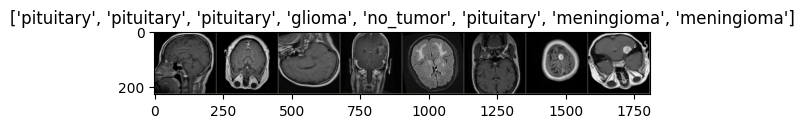

In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
class SepConv2d(nn.Module):
    """Separable Convolution = Depthwise Convolution + Pointwise Convolution"""
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False):
        super().__init__()
        self.depth = nn.Conv2d(in_ch, in_ch, kernel_size=kernel_size, stride=stride,
                               padding=padding, groups=in_ch, bias=bias)
        self.point = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, bias=bias)

    def forward(self, x):
        x = self.depth(x)
        x = self.point(x)
        return x


class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        reduced = max(1, channels // reduction)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(channels, reduced)
        self.fc2 = nn.Linear(reduced, channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = torch.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y


class ConvBlock(nn.Module):
    """ConvBlock: SepConv -> BN -> ReLU -> MaxPool -> SEBlock"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.seq = nn.Sequential(
            SepConv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            SEBlock(out_ch)
        )

    def forward(self, x):
        x = self.seq(x)
        return x

In [9]:
class LightCNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=4):
        super().__init__()
        self.block1 = ConvBlock(in_channels, 32)
        self.block2 = ConvBlock(32, 64)
        self.block3 = ConvBlock(64, 128)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(128, 128)
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.drop1(x)
        x = torch.relu(self.fc2(x))
        x = self.drop2(x)
        logits = self.fc3(x)
        return logits


model = LightCNN(in_channels=3, num_classes=len(class_names)).to(device)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params}\nTotal Trainable Parameters: {trainable_params}")

Total params: 39629
Total Trainable Parameters: 39629


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

In [11]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.5):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("inf")
        self.early_stop = False

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True

In [12]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    pbar = tqdm(dataloader, desc='train', leave=False)
    for inputs, labels in pbar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        preds = torch.argmax(outputs, dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        pbar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    return epoch_loss, epoch_acc

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='valid', leave=False)
        for inputs, labels in pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    return epoch_loss, epoch_acc, all_preds, all_labels

In [13]:
NUM_EPOCHS = 300
best_val_acc = 0.0
best_model_path = 'best_custom_model.h5'

early_stopper = EarlyStopping(patience=5)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    train_loss, train_acc = train_one_epoch(model, dataloaders['train'], criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_labels = validate_one_epoch(model, dataloaders['valid'], criterion, device)

    scheduler.step(val_loss)
    early_stopper.step(val_loss)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"    train_loss: {train_loss:.4f}    train_acc: {train_acc:.4f}")
    print(f"    val_loss: {val_loss:.4f}    val_acc: {val_acc:.4f}")

    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'class_names': class_names
        }, best_model_path)
        print(f"Saved new best model")

total_time = time.time() - start_time
print(f"Training Complete in {total_time/60:.2f} minutes. Best val acc: {best_val_acc:.4f}'")

Epoch 1/300


    train_loss: 1.1596    train_acc: 0.4838
    val_loss: 1.0756    val_acc: 0.5797
Saved new best model
Epoch 2/300


    train_loss: 0.9955    train_acc: 0.5971
    val_loss: 0.8401    val_acc: 0.6633
Saved new best model
Epoch 3/300


    train_loss: 0.9324    train_acc: 0.6277
    val_loss: 0.8398    val_acc: 0.6713
Saved new best model
Epoch 4/300


    train_loss: 0.9295    train_acc: 0.6389
    val_loss: 0.7995    val_acc: 0.7191
Saved new best model
Epoch 5/300


    train_loss: 0.9061    train_acc: 0.6413
    val_loss: 0.7455    val_acc: 0.6833
Epoch 6/300


    train_loss: 0.8785    train_acc: 0.6513
    val_loss: 0.6877    val_acc: 0.7251
Saved new best model
Epoch 7/300


    train_loss: 0.8178    train_acc: 0.6796
    val_loss: 0.9014    val_acc: 0.6255
Epoch 8/300


    train_loss: 0.8441    train_acc: 0.6649
    val_loss: 0.8219    val_acc: 0.7271
Saved new best model
Epoch 9/300


    train_loss: 0.8022    train_acc: 0.6814
    val_loss: 1.0625    val_acc: 0.6394
Epoch 10/300


    train_loss: 0.7452    train_acc: 0.7162
    val_loss: 0.9846    val_acc: 0.6195
Epoch 11/300


    train_loss: 0.7229    train_acc: 0.7080
    val_loss: 0.5670    val_acc: 0.7968
Saved new best model
Epoch 12/300


    train_loss: 0.6899    train_acc: 0.7168
    val_loss: 0.5604    val_acc: 0.7988
Saved new best model
Epoch 13/300


    train_loss: 0.7037    train_acc: 0.7097
    val_loss: 0.6038    val_acc: 0.7649
Epoch 14/300


    train_loss: 0.6823    train_acc: 0.7304
    val_loss: 0.5292    val_acc: 0.8347
Saved new best model
Epoch 15/300


    train_loss: 0.6638    train_acc: 0.7422
    val_loss: 0.8323    val_acc: 0.6932
Epoch 16/300


    train_loss: 0.6370    train_acc: 0.7499
    val_loss: 0.5640    val_acc: 0.7669
Epoch 17/300


    train_loss: 0.6522    train_acc: 0.7398
    val_loss: 0.5984    val_acc: 0.7490
Epoch 18/300


    train_loss: 0.6173    train_acc: 0.7652
    val_loss: 0.5281    val_acc: 0.8127
Epoch 19/300


    train_loss: 0.5764    train_acc: 0.7770
    val_loss: 0.6643    val_acc: 0.7430
Epoch 20/300


    train_loss: 0.6221    train_acc: 0.7605
    val_loss: 0.6431    val_acc: 0.7311
Epoch 21/300


    train_loss: 0.6022    train_acc: 0.7634
    val_loss: 0.5476    val_acc: 0.8008
Epoch 22/300


    train_loss: 0.6166    train_acc: 0.7593
    val_loss: 0.5014    val_acc: 0.8147
Epoch 23/300


    train_loss: 0.5760    train_acc: 0.7752
    val_loss: 0.4616    val_acc: 0.8446
Saved new best model
Epoch 24/300


    train_loss: 0.5797    train_acc: 0.7805
    val_loss: 0.5017    val_acc: 0.8207
Epoch 25/300


    train_loss: 0.5535    train_acc: 0.7823
    val_loss: 0.4109    val_acc: 0.8526
Saved new best model
Epoch 26/300


    train_loss: 0.5573    train_acc: 0.7811
    val_loss: 0.4789    val_acc: 0.8127
Epoch 27/300


    train_loss: 0.5565    train_acc: 0.7971
    val_loss: 0.5847    val_acc: 0.7570
Epoch 28/300


    train_loss: 0.5524    train_acc: 0.7882
    val_loss: 0.4529    val_acc: 0.8386
Epoch 29/300


    train_loss: 0.5425    train_acc: 0.7917
    val_loss: 0.4372    val_acc: 0.8486
Epoch 30/300


    train_loss: 0.5369    train_acc: 0.8029
    val_loss: 0.4342    val_acc: 0.8546
Saved new best model
Epoch 31/300


    train_loss: 0.4984    train_acc: 0.8088
    val_loss: 0.4078    val_acc: 0.8625
Saved new best model
Epoch 32/300


    train_loss: 0.4746    train_acc: 0.8171
    val_loss: 0.5185    val_acc: 0.7888
Epoch 33/300


    train_loss: 0.5006    train_acc: 0.8112
    val_loss: 0.4279    val_acc: 0.8446
Epoch 34/300


    train_loss: 0.4858    train_acc: 0.8130
    val_loss: 0.5662    val_acc: 0.7928
Epoch 35/300


    train_loss: 0.4988    train_acc: 0.8094
    val_loss: 0.5788    val_acc: 0.7829
Epoch 36/300


    train_loss: 0.4717    train_acc: 0.8212
    val_loss: 0.4326    val_acc: 0.8486
Epoch 37/300


    train_loss: 0.4537    train_acc: 0.8230
    val_loss: 0.4058    val_acc: 0.8546
Epoch 38/300


    train_loss: 0.4703    train_acc: 0.8248
    val_loss: 0.4858    val_acc: 0.8108
Epoch 39/300


    train_loss: 0.4840    train_acc: 0.8189
    val_loss: 0.4025    val_acc: 0.8486
Epoch 40/300


    train_loss: 0.4647    train_acc: 0.8354
    val_loss: 0.4376    val_acc: 0.8406
Epoch 41/300


    train_loss: 0.4754    train_acc: 0.8218
    val_loss: 0.4737    val_acc: 0.8247
Epoch 42/300


    train_loss: 0.4557    train_acc: 0.8248
    val_loss: 0.4180    val_acc: 0.8645
Saved new best model
Epoch 43/300


    train_loss: 0.4787    train_acc: 0.8206
    val_loss: 0.4451    val_acc: 0.8287
Epoch 44/300


    train_loss: 0.4387    train_acc: 0.8383
    val_loss: 0.4302    val_acc: 0.8446
Epoch 45/300


    train_loss: 0.4387    train_acc: 0.8389
    val_loss: 0.3811    val_acc: 0.8665
Saved new best model
Epoch 46/300


    train_loss: 0.4380    train_acc: 0.8460
    val_loss: 0.4115    val_acc: 0.8606
Epoch 47/300


    train_loss: 0.4553    train_acc: 0.8372
    val_loss: 0.4547    val_acc: 0.8347
Epoch 48/300


    train_loss: 0.4267    train_acc: 0.8478
    val_loss: 0.4408    val_acc: 0.8347
Epoch 49/300


    train_loss: 0.4498    train_acc: 0.8354
    val_loss: 0.3767    val_acc: 0.8705
Saved new best model
Epoch 50/300


    train_loss: 0.4513    train_acc: 0.8254
    val_loss: 0.4054    val_acc: 0.8486
Epoch 51/300


    train_loss: 0.4334    train_acc: 0.8460
    val_loss: 0.4315    val_acc: 0.8406
Epoch 52/300


    train_loss: 0.4434    train_acc: 0.8401
    val_loss: 0.4040    val_acc: 0.8526
Epoch 53/300


    train_loss: 0.4280    train_acc: 0.8383
    val_loss: 0.3963    val_acc: 0.8566
Epoch 54/300


    train_loss: 0.4655    train_acc: 0.8324
    val_loss: 0.3737    val_acc: 0.8606
Epoch 55/300


    train_loss: 0.4263    train_acc: 0.8407
    val_loss: 0.4035    val_acc: 0.8486
Epoch 56/300


    train_loss: 0.4384    train_acc: 0.8342
    val_loss: 0.3907    val_acc: 0.8586
Epoch 57/300


    train_loss: 0.4122    train_acc: 0.8507
    val_loss: 0.3693    val_acc: 0.8785
Saved new best model
Epoch 58/300


    train_loss: 0.4308    train_acc: 0.8448
    val_loss: 0.3850    val_acc: 0.8645
Epoch 59/300


    train_loss: 0.4484    train_acc: 0.8236
    val_loss: 0.4004    val_acc: 0.8586
Epoch 60/300


    train_loss: 0.4318    train_acc: 0.8472
    val_loss: 0.4003    val_acc: 0.8566
Epoch 61/300


    train_loss: 0.4335    train_acc: 0.8454
    val_loss: 0.3940    val_acc: 0.8586
Epoch 62/300


    train_loss: 0.4249    train_acc: 0.8354
    val_loss: 0.3928    val_acc: 0.8625
Epoch 63/300


    train_loss: 0.4224    train_acc: 0.8378
    val_loss: 0.3766    val_acc: 0.8725
Epoch 64/300


    train_loss: 0.4133    train_acc: 0.8442
    val_loss: 0.3927    val_acc: 0.8625
Epoch 65/300


    train_loss: 0.4054    train_acc: 0.8667
    val_loss: 0.4166    val_acc: 0.8526
Epoch 66/300


    train_loss: 0.4333    train_acc: 0.8342
    val_loss: 0.4150    val_acc: 0.8486
Epoch 67/300


    train_loss: 0.4341    train_acc: 0.8419
    val_loss: 0.3940    val_acc: 0.8506
Epoch 68/300


    train_loss: 0.4263    train_acc: 0.8401
    val_loss: 0.3874    val_acc: 0.8546
Epoch 69/300


    train_loss: 0.4308    train_acc: 0.8319
    val_loss: 0.3894    val_acc: 0.8645
Epoch 70/300


    train_loss: 0.4158    train_acc: 0.8354
    val_loss: 0.3846    val_acc: 0.8665
Epoch 71/300


    train_loss: 0.4421    train_acc: 0.8401
    val_loss: 0.3869    val_acc: 0.8526
Epoch 72/300


    train_loss: 0.4230    train_acc: 0.8389
    val_loss: 0.3870    val_acc: 0.8566
Epoch 73/300


    train_loss: 0.4155    train_acc: 0.8537
    val_loss: 0.3746    val_acc: 0.8606
Epoch 74/300


    train_loss: 0.4137    train_acc: 0.8501
    val_loss: 0.4046    val_acc: 0.8486
Epoch 75/300


    train_loss: 0.4211    train_acc: 0.8442
    val_loss: 0.3710    val_acc: 0.8785
Epoch 76/300


    train_loss: 0.4199    train_acc: 0.8413
    val_loss: 0.4000    val_acc: 0.8506
Epoch 77/300


    train_loss: 0.4040    train_acc: 0.8602
    val_loss: 0.4125    val_acc: 0.8526
Epoch 78/300


    train_loss: 0.4183    train_acc: 0.8560
    val_loss: 0.3932    val_acc: 0.8526
Epoch 79/300


    train_loss: 0.4089    train_acc: 0.8490
    val_loss: 0.3870    val_acc: 0.8625
Epoch 80/300


    train_loss: 0.4281    train_acc: 0.8419
    val_loss: 0.4182    val_acc: 0.8506
Epoch 81/300


    train_loss: 0.4263    train_acc: 0.8425
    val_loss: 0.4190    val_acc: 0.8486
Epoch 82/300


    train_loss: 0.4316    train_acc: 0.8437
    val_loss: 0.3838    val_acc: 0.8645
Epoch 83/300


    train_loss: 0.4246    train_acc: 0.8389
    val_loss: 0.4343    val_acc: 0.8367
Epoch 84/300


    train_loss: 0.4149    train_acc: 0.8507
    val_loss: 0.4164    val_acc: 0.8426
Epoch 85/300


    train_loss: 0.4172    train_acc: 0.8354
    val_loss: 0.4132    val_acc: 0.8546
Epoch 86/300


    train_loss: 0.4240    train_acc: 0.8454
    val_loss: 0.4021    val_acc: 0.8406
Epoch 87/300


    train_loss: 0.4393    train_acc: 0.8348
    val_loss: 0.4043    val_acc: 0.8566
Epoch 88/300


    train_loss: 0.4096    train_acc: 0.8519
    val_loss: 0.3823    val_acc: 0.8645
Epoch 89/300


    train_loss: 0.4377    train_acc: 0.8378
    val_loss: 0.4071    val_acc: 0.8426
Epoch 90/300


    train_loss: 0.4077    train_acc: 0.8531
    val_loss: 0.4062    val_acc: 0.8546
Epoch 91/300


    train_loss: 0.4068    train_acc: 0.8460
    val_loss: 0.3902    val_acc: 0.8566
Epoch 92/300


    train_loss: 0.4201    train_acc: 0.8437
    val_loss: 0.3733    val_acc: 0.8745
Epoch 93/300


    train_loss: 0.4248    train_acc: 0.8425
    val_loss: 0.3784    val_acc: 0.8645
Epoch 94/300


    train_loss: 0.4205    train_acc: 0.8431
    val_loss: 0.3740    val_acc: 0.8665
Epoch 95/300


    train_loss: 0.4356    train_acc: 0.8378
    val_loss: 0.3961    val_acc: 0.8446
Epoch 96/300


    train_loss: 0.4207    train_acc: 0.8448
    val_loss: 0.3865    val_acc: 0.8546
Epoch 97/300


    train_loss: 0.4232    train_acc: 0.8466
    val_loss: 0.3834    val_acc: 0.8625
Epoch 98/300


    train_loss: 0.4160    train_acc: 0.8507
    val_loss: 0.3833    val_acc: 0.8625
Epoch 99/300


    train_loss: 0.4139    train_acc: 0.8507
    val_loss: 0.4417    val_acc: 0.8386
Epoch 100/300


    train_loss: 0.4230    train_acc: 0.8330
    val_loss: 0.3883    val_acc: 0.8586
Epoch 101/300


    train_loss: 0.4046    train_acc: 0.8525
    val_loss: 0.3903    val_acc: 0.8606
Epoch 102/300


    train_loss: 0.4201    train_acc: 0.8460
    val_loss: 0.4022    val_acc: 0.8586
Epoch 103/300


    train_loss: 0.4275    train_acc: 0.8490
    val_loss: 0.3833    val_acc: 0.8625
Epoch 104/300


    train_loss: 0.4197    train_acc: 0.8507
    val_loss: 0.3933    val_acc: 0.8566
Epoch 105/300


    train_loss: 0.4306    train_acc: 0.8448
    val_loss: 0.3943    val_acc: 0.8566
Epoch 106/300


    train_loss: 0.4212    train_acc: 0.8466
    val_loss: 0.3916    val_acc: 0.8586
Epoch 107/300


    train_loss: 0.4165    train_acc: 0.8454
    val_loss: 0.3839    val_acc: 0.8625
Epoch 108/300


    train_loss: 0.4203    train_acc: 0.8419
    val_loss: 0.3938    val_acc: 0.8625
Epoch 109/300


    train_loss: 0.4318    train_acc: 0.8425
    val_loss: 0.4076    val_acc: 0.8546
Epoch 110/300


    train_loss: 0.4063    train_acc: 0.8460
    val_loss: 0.3918    val_acc: 0.8606
Epoch 111/300


    train_loss: 0.4082    train_acc: 0.8472
    val_loss: 0.4098    val_acc: 0.8566
Epoch 112/300


    train_loss: 0.4240    train_acc: 0.8395
    val_loss: 0.4021    val_acc: 0.8566
Epoch 113/300


    train_loss: 0.4155    train_acc: 0.8578
    val_loss: 0.4048    val_acc: 0.8546
Epoch 114/300


    train_loss: 0.4265    train_acc: 0.8395
    val_loss: 0.3814    val_acc: 0.8625
Epoch 115/300


    train_loss: 0.4252    train_acc: 0.8472
    val_loss: 0.3957    val_acc: 0.8426
Epoch 116/300


    train_loss: 0.4181    train_acc: 0.8378
    val_loss: 0.4013    val_acc: 0.8586
Epoch 117/300


    train_loss: 0.4234    train_acc: 0.8454
    val_loss: 0.4170    val_acc: 0.8386
Epoch 118/300


    train_loss: 0.4144    train_acc: 0.8507
    val_loss: 0.4200    val_acc: 0.8546
Epoch 119/300


    train_loss: 0.4186    train_acc: 0.8407
    val_loss: 0.3909    val_acc: 0.8486
Epoch 120/300


    train_loss: 0.4117    train_acc: 0.8437
    val_loss: 0.3836    val_acc: 0.8606
Epoch 121/300


    train_loss: 0.4276    train_acc: 0.8313
    val_loss: 0.3932    val_acc: 0.8506
Epoch 122/300


    train_loss: 0.4231    train_acc: 0.8490
    val_loss: 0.3814    val_acc: 0.8645
Epoch 123/300


    train_loss: 0.4246    train_acc: 0.8448
    val_loss: 0.3791    val_acc: 0.8506
Epoch 124/300


    train_loss: 0.4265    train_acc: 0.8360
    val_loss: 0.3911    val_acc: 0.8566
Epoch 125/300


    train_loss: 0.3961    train_acc: 0.8472
    val_loss: 0.4024    val_acc: 0.8486
Epoch 126/300


    train_loss: 0.3976    train_acc: 0.8531
    val_loss: 0.3943    val_acc: 0.8506
Epoch 127/300


    train_loss: 0.4123    train_acc: 0.8466
    val_loss: 0.3763    val_acc: 0.8625
Epoch 128/300


    train_loss: 0.4212    train_acc: 0.8478
    val_loss: 0.3810    val_acc: 0.8725
Epoch 129/300


    train_loss: 0.4103    train_acc: 0.8431
    val_loss: 0.3998    val_acc: 0.8586
Epoch 130/300


    train_loss: 0.4237    train_acc: 0.8437
    val_loss: 0.4017    val_acc: 0.8586
Epoch 131/300


    train_loss: 0.4122    train_acc: 0.8537
    val_loss: 0.3954    val_acc: 0.8625
Epoch 132/300


    train_loss: 0.4120    train_acc: 0.8425
    val_loss: 0.3910    val_acc: 0.8506
Epoch 133/300


    train_loss: 0.4275    train_acc: 0.8466
    val_loss: 0.3906    val_acc: 0.8625
Epoch 134/300


    train_loss: 0.4203    train_acc: 0.8466
    val_loss: 0.3867    val_acc: 0.8486
Epoch 135/300


    train_loss: 0.4038    train_acc: 0.8525
    val_loss: 0.3941    val_acc: 0.8486
Epoch 136/300


    train_loss: 0.4103    train_acc: 0.8501
    val_loss: 0.3988    val_acc: 0.8606
Epoch 137/300


    train_loss: 0.4196    train_acc: 0.8472
    val_loss: 0.4220    val_acc: 0.8466
Epoch 138/300


    train_loss: 0.4072    train_acc: 0.8513
    val_loss: 0.3989    val_acc: 0.8486
Epoch 139/300


    train_loss: 0.4308    train_acc: 0.8490
    val_loss: 0.3901    val_acc: 0.8625
Epoch 140/300


    train_loss: 0.4205    train_acc: 0.8413
    val_loss: 0.4119    val_acc: 0.8566
Epoch 141/300


    train_loss: 0.4073    train_acc: 0.8478
    val_loss: 0.3936    val_acc: 0.8546
Epoch 142/300


    train_loss: 0.4297    train_acc: 0.8354
    val_loss: 0.3914    val_acc: 0.8606
Epoch 143/300


    train_loss: 0.4357    train_acc: 0.8354
    val_loss: 0.4169    val_acc: 0.8546
Epoch 144/300


    train_loss: 0.4209    train_acc: 0.8454
    val_loss: 0.4105    val_acc: 0.8546
Epoch 145/300


    train_loss: 0.4327    train_acc: 0.8460
    val_loss: 0.3803    val_acc: 0.8645
Epoch 146/300


    train_loss: 0.3969    train_acc: 0.8555
    val_loss: 0.3930    val_acc: 0.8606
Epoch 147/300


    train_loss: 0.4165    train_acc: 0.8419
    val_loss: 0.4035    val_acc: 0.8586
Epoch 148/300


    train_loss: 0.4188    train_acc: 0.8448
    val_loss: 0.4103    val_acc: 0.8546
Epoch 149/300


    train_loss: 0.4073    train_acc: 0.8501
    val_loss: 0.3914    val_acc: 0.8606
Epoch 150/300


    train_loss: 0.4349    train_acc: 0.8454
    val_loss: 0.4064    val_acc: 0.8566
Epoch 151/300


    train_loss: 0.3874    train_acc: 0.8501
    val_loss: 0.4079    val_acc: 0.8586
Epoch 152/300


    train_loss: 0.4327    train_acc: 0.8383
    val_loss: 0.3810    val_acc: 0.8625
Epoch 153/300


    train_loss: 0.4313    train_acc: 0.8401
    val_loss: 0.4033    val_acc: 0.8586
Epoch 154/300


    train_loss: 0.4137    train_acc: 0.8389
    val_loss: 0.4280    val_acc: 0.8327
Epoch 155/300


    train_loss: 0.4149    train_acc: 0.8507
    val_loss: 0.3736    val_acc: 0.8606
Epoch 156/300


    train_loss: 0.4105    train_acc: 0.8484
    val_loss: 0.3921    val_acc: 0.8526
Epoch 157/300


    train_loss: 0.4283    train_acc: 0.8413
    val_loss: 0.3960    val_acc: 0.8566
Epoch 158/300


    train_loss: 0.4286    train_acc: 0.8366
    val_loss: 0.4095    val_acc: 0.8466
Epoch 159/300


    train_loss: 0.4205    train_acc: 0.8484
    val_loss: 0.3831    val_acc: 0.8606
Epoch 160/300


    train_loss: 0.4126    train_acc: 0.8448
    val_loss: 0.4023    val_acc: 0.8546
Epoch 161/300


    train_loss: 0.4321    train_acc: 0.8389
    val_loss: 0.3879    val_acc: 0.8506
Epoch 162/300


    train_loss: 0.4360    train_acc: 0.8372
    val_loss: 0.4018    val_acc: 0.8586
Epoch 163/300


    train_loss: 0.4244    train_acc: 0.8454
    val_loss: 0.4019    val_acc: 0.8606
Epoch 164/300


    train_loss: 0.4191    train_acc: 0.8460
    val_loss: 0.4099    val_acc: 0.8586
Epoch 165/300


    train_loss: 0.4206    train_acc: 0.8490
    val_loss: 0.3816    val_acc: 0.8586
Epoch 166/300


    train_loss: 0.4192    train_acc: 0.8360
    val_loss: 0.3794    val_acc: 0.8606
Epoch 167/300


    train_loss: 0.4223    train_acc: 0.8389
    val_loss: 0.3857    val_acc: 0.8546
Epoch 168/300


    train_loss: 0.4314    train_acc: 0.8407
    val_loss: 0.3958    val_acc: 0.8606
Epoch 169/300


    train_loss: 0.4175    train_acc: 0.8543
    val_loss: 0.3986    val_acc: 0.8506
Epoch 170/300


    train_loss: 0.4399    train_acc: 0.8395
    val_loss: 0.4025    val_acc: 0.8566
Epoch 171/300


    train_loss: 0.4230    train_acc: 0.8460
    val_loss: 0.4024    val_acc: 0.8566
Epoch 172/300


    train_loss: 0.4084    train_acc: 0.8437
    val_loss: 0.3940    val_acc: 0.8586
Epoch 173/300


    train_loss: 0.4240    train_acc: 0.8383
    val_loss: 0.3914    val_acc: 0.8586
Epoch 174/300


    train_loss: 0.4365    train_acc: 0.8484
    val_loss: 0.3952    val_acc: 0.8606
Epoch 175/300


    train_loss: 0.4183    train_acc: 0.8378
    val_loss: 0.3934    val_acc: 0.8526
Epoch 176/300


    train_loss: 0.4259    train_acc: 0.8354
    val_loss: 0.4015    val_acc: 0.8546
Epoch 177/300


    train_loss: 0.4192    train_acc: 0.8454
    val_loss: 0.4010    val_acc: 0.8586
Epoch 178/300


    train_loss: 0.4318    train_acc: 0.8383
    val_loss: 0.3763    val_acc: 0.8606
Epoch 179/300


    train_loss: 0.4254    train_acc: 0.8472
    val_loss: 0.3925    val_acc: 0.8546
Epoch 180/300


    train_loss: 0.3956    train_acc: 0.8519
    val_loss: 0.3983    val_acc: 0.8506
Epoch 181/300


    train_loss: 0.4068    train_acc: 0.8584
    val_loss: 0.3899    val_acc: 0.8606
Epoch 182/300


    train_loss: 0.4283    train_acc: 0.8407
    val_loss: 0.4046    val_acc: 0.8526
Epoch 183/300


    train_loss: 0.4312    train_acc: 0.8383
    val_loss: 0.3902    val_acc: 0.8645
Epoch 184/300


    train_loss: 0.4121    train_acc: 0.8431
    val_loss: 0.4059    val_acc: 0.8586
Epoch 185/300


    train_loss: 0.4390    train_acc: 0.8307
    val_loss: 0.4092    val_acc: 0.8486
Epoch 186/300


    train_loss: 0.4411    train_acc: 0.8336
    val_loss: 0.3838    val_acc: 0.8665
Epoch 187/300


    train_loss: 0.4059    train_acc: 0.8507
    val_loss: 0.3964    val_acc: 0.8566
Epoch 188/300


    train_loss: 0.4236    train_acc: 0.8425
    val_loss: 0.3920    val_acc: 0.8566
Epoch 189/300


    train_loss: 0.4269    train_acc: 0.8395
    val_loss: 0.3780    val_acc: 0.8725
Epoch 190/300


    train_loss: 0.4154    train_acc: 0.8460
    val_loss: 0.4027    val_acc: 0.8526
Epoch 191/300


    train_loss: 0.4201    train_acc: 0.8307
    val_loss: 0.4004    val_acc: 0.8486
Epoch 192/300


    train_loss: 0.4078    train_acc: 0.8401
    val_loss: 0.3871    val_acc: 0.8606
Epoch 193/300


    train_loss: 0.4319    train_acc: 0.8395
    val_loss: 0.4022    val_acc: 0.8466
Epoch 194/300


    train_loss: 0.4278    train_acc: 0.8478
    val_loss: 0.3886    val_acc: 0.8526
Epoch 195/300


    train_loss: 0.4100    train_acc: 0.8525
    val_loss: 0.3988    val_acc: 0.8586
Epoch 196/300


    train_loss: 0.4176    train_acc: 0.8496
    val_loss: 0.4077    val_acc: 0.8586
Epoch 197/300


    train_loss: 0.4058    train_acc: 0.8460
    val_loss: 0.3852    val_acc: 0.8566
Epoch 198/300


    train_loss: 0.4154    train_acc: 0.8437
    val_loss: 0.4091    val_acc: 0.8586
Epoch 199/300


    train_loss: 0.4241    train_acc: 0.8466
    val_loss: 0.4043    val_acc: 0.8586
Epoch 200/300


    train_loss: 0.4323    train_acc: 0.8454
    val_loss: 0.4139    val_acc: 0.8426
Epoch 201/300


    train_loss: 0.4161    train_acc: 0.8496
    val_loss: 0.3900    val_acc: 0.8645
Epoch 202/300


    train_loss: 0.4243    train_acc: 0.8431
    val_loss: 0.3999    val_acc: 0.8526
Epoch 203/300


    train_loss: 0.4067    train_acc: 0.8513
    val_loss: 0.3758    val_acc: 0.8625
Epoch 204/300


    train_loss: 0.4111    train_acc: 0.8478
    val_loss: 0.4135    val_acc: 0.8566
Epoch 205/300


    train_loss: 0.4091    train_acc: 0.8549
    val_loss: 0.3906    val_acc: 0.8586
Epoch 206/300


    train_loss: 0.4333    train_acc: 0.8478
    val_loss: 0.3889    val_acc: 0.8625
Epoch 207/300


    train_loss: 0.4335    train_acc: 0.8407
    val_loss: 0.4190    val_acc: 0.8506
Epoch 208/300


    train_loss: 0.4154    train_acc: 0.8419
    val_loss: 0.3749    val_acc: 0.8705
Epoch 209/300


    train_loss: 0.4100    train_acc: 0.8460
    val_loss: 0.4114    val_acc: 0.8466
Epoch 210/300


    train_loss: 0.4234    train_acc: 0.8419
    val_loss: 0.3976    val_acc: 0.8546
Epoch 211/300


    train_loss: 0.4297    train_acc: 0.8401
    val_loss: 0.4163    val_acc: 0.8546
Epoch 212/300


    train_loss: 0.4032    train_acc: 0.8572
    val_loss: 0.4089    val_acc: 0.8526
Epoch 213/300


    train_loss: 0.4312    train_acc: 0.8348
    val_loss: 0.3831    val_acc: 0.8645
Epoch 214/300


    train_loss: 0.3962    train_acc: 0.8655
    val_loss: 0.4059    val_acc: 0.8586
Epoch 215/300


    train_loss: 0.4134    train_acc: 0.8472
    val_loss: 0.3840    val_acc: 0.8566
Epoch 216/300


    train_loss: 0.4289    train_acc: 0.8419
    val_loss: 0.3880    val_acc: 0.8606
Epoch 217/300


    train_loss: 0.4167    train_acc: 0.8454
    val_loss: 0.3911    val_acc: 0.8406
Epoch 218/300


    train_loss: 0.4236    train_acc: 0.8360
    val_loss: 0.4302    val_acc: 0.8466
Epoch 219/300


    train_loss: 0.4358    train_acc: 0.8383
    val_loss: 0.3879    val_acc: 0.8625
Epoch 220/300


    train_loss: 0.4171    train_acc: 0.8383
    val_loss: 0.3939    val_acc: 0.8446
Epoch 221/300


    train_loss: 0.3897    train_acc: 0.8661
    val_loss: 0.3939    val_acc: 0.8645
Epoch 222/300


    train_loss: 0.4398    train_acc: 0.8319
    val_loss: 0.4188    val_acc: 0.8546
Epoch 223/300


    train_loss: 0.4050    train_acc: 0.8490
    val_loss: 0.4176    val_acc: 0.8506
Epoch 224/300


    train_loss: 0.4196    train_acc: 0.8413
    val_loss: 0.4118    val_acc: 0.8546
Epoch 225/300


    train_loss: 0.4082    train_acc: 0.8454
    val_loss: 0.4098    val_acc: 0.8506
Epoch 226/300


    train_loss: 0.4167    train_acc: 0.8442
    val_loss: 0.3747    val_acc: 0.8705
Epoch 227/300


    train_loss: 0.4081    train_acc: 0.8490
    val_loss: 0.3982    val_acc: 0.8586
Epoch 228/300


    train_loss: 0.4203    train_acc: 0.8395
    val_loss: 0.3797    val_acc: 0.8685
Epoch 229/300


    train_loss: 0.4079    train_acc: 0.8496
    val_loss: 0.4128    val_acc: 0.8566
Epoch 230/300


    train_loss: 0.4166    train_acc: 0.8431
    val_loss: 0.3910    val_acc: 0.8526
Epoch 231/300


    train_loss: 0.4236    train_acc: 0.8389
    val_loss: 0.3990    val_acc: 0.8546
Epoch 232/300


    train_loss: 0.4274    train_acc: 0.8383
    val_loss: 0.4009    val_acc: 0.8606
Epoch 233/300


    train_loss: 0.4067    train_acc: 0.8454
    val_loss: 0.3646    val_acc: 0.8685
Epoch 234/300


    train_loss: 0.4493    train_acc: 0.8313
    val_loss: 0.3696    val_acc: 0.8765
Epoch 235/300


    train_loss: 0.4156    train_acc: 0.8383
    val_loss: 0.3988    val_acc: 0.8566
Epoch 236/300


    train_loss: 0.4204    train_acc: 0.8460
    val_loss: 0.3859    val_acc: 0.8625
Epoch 237/300


    train_loss: 0.4201    train_acc: 0.8484
    val_loss: 0.4029    val_acc: 0.8586
Epoch 238/300


    train_loss: 0.4122    train_acc: 0.8513
    val_loss: 0.3882    val_acc: 0.8625
Epoch 239/300


    train_loss: 0.3993    train_acc: 0.8448
    val_loss: 0.3908    val_acc: 0.8606
Epoch 240/300


    train_loss: 0.4018    train_acc: 0.8501
    val_loss: 0.3952    val_acc: 0.8586
Epoch 241/300


    train_loss: 0.4313    train_acc: 0.8348
    val_loss: 0.4160    val_acc: 0.8526
Epoch 242/300


    train_loss: 0.4342    train_acc: 0.8448
    val_loss: 0.3857    val_acc: 0.8645
Epoch 243/300


    train_loss: 0.4290    train_acc: 0.8442
    val_loss: 0.3940    val_acc: 0.8586
Epoch 244/300


    train_loss: 0.4272    train_acc: 0.8472
    val_loss: 0.3947    val_acc: 0.8625
Epoch 245/300


    train_loss: 0.4126    train_acc: 0.8478
    val_loss: 0.3907    val_acc: 0.8645
Epoch 246/300


    train_loss: 0.4141    train_acc: 0.8478
    val_loss: 0.4079    val_acc: 0.8546
Epoch 247/300


    train_loss: 0.4298    train_acc: 0.8490
    val_loss: 0.3922    val_acc: 0.8586
Epoch 248/300


    train_loss: 0.4180    train_acc: 0.8484
    val_loss: 0.4022    val_acc: 0.8586
Epoch 249/300


    train_loss: 0.4199    train_acc: 0.8448
    val_loss: 0.3816    val_acc: 0.8606
Epoch 250/300


    train_loss: 0.4098    train_acc: 0.8419
    val_loss: 0.4143    val_acc: 0.8486
Epoch 251/300


    train_loss: 0.4312    train_acc: 0.8419
    val_loss: 0.4214    val_acc: 0.8426
Epoch 252/300


    train_loss: 0.4124    train_acc: 0.8566
    val_loss: 0.3827    val_acc: 0.8625
Epoch 253/300


    train_loss: 0.4039    train_acc: 0.8466
    val_loss: 0.4012    val_acc: 0.8606
Epoch 254/300


    train_loss: 0.4229    train_acc: 0.8413
    val_loss: 0.4030    val_acc: 0.8566
Epoch 255/300


    train_loss: 0.4166    train_acc: 0.8466
    val_loss: 0.4084    val_acc: 0.8606
Epoch 256/300


    train_loss: 0.4201    train_acc: 0.8378
    val_loss: 0.3833    val_acc: 0.8665
Epoch 257/300


    train_loss: 0.4217    train_acc: 0.8466
    val_loss: 0.3968    val_acc: 0.8586
Epoch 258/300


    train_loss: 0.4346    train_acc: 0.8395
    val_loss: 0.3890    val_acc: 0.8566
Epoch 259/300


    train_loss: 0.4420    train_acc: 0.8330
    val_loss: 0.4009    val_acc: 0.8586
Epoch 260/300


    train_loss: 0.4131    train_acc: 0.8401
    val_loss: 0.4040    val_acc: 0.8566
Epoch 261/300


    train_loss: 0.4312    train_acc: 0.8360
    val_loss: 0.3825    val_acc: 0.8665
Epoch 262/300


    train_loss: 0.4065    train_acc: 0.8531
    val_loss: 0.3877    val_acc: 0.8586
Epoch 263/300


    train_loss: 0.4198    train_acc: 0.8366
    val_loss: 0.3811    val_acc: 0.8665
Epoch 264/300


    train_loss: 0.3947    train_acc: 0.8507
    val_loss: 0.3769    val_acc: 0.8725
Epoch 265/300


    train_loss: 0.4217    train_acc: 0.8407
    val_loss: 0.3940    val_acc: 0.8606
Epoch 266/300


    train_loss: 0.4155    train_acc: 0.8395
    val_loss: 0.4009    val_acc: 0.8566
Epoch 267/300


    train_loss: 0.4224    train_acc: 0.8460
    val_loss: 0.3855    val_acc: 0.8566
Epoch 268/300


    train_loss: 0.4276    train_acc: 0.8442
    val_loss: 0.3930    val_acc: 0.8665
Epoch 269/300


    train_loss: 0.4334    train_acc: 0.8366
    val_loss: 0.3844    val_acc: 0.8625
Epoch 270/300


    train_loss: 0.4291    train_acc: 0.8378
    val_loss: 0.3987    val_acc: 0.8566
Epoch 271/300


    train_loss: 0.4312    train_acc: 0.8431
    val_loss: 0.4214    val_acc: 0.8446
Epoch 272/300


    train_loss: 0.4257    train_acc: 0.8419
    val_loss: 0.4058    val_acc: 0.8546
Epoch 273/300


    train_loss: 0.4179    train_acc: 0.8478
    val_loss: 0.3844    val_acc: 0.8586
Epoch 274/300


    train_loss: 0.4206    train_acc: 0.8466
    val_loss: 0.3881    val_acc: 0.8625
Epoch 275/300


    train_loss: 0.4162    train_acc: 0.8407
    val_loss: 0.3875    val_acc: 0.8625
Epoch 276/300


    train_loss: 0.4355    train_acc: 0.8407
    val_loss: 0.4012    val_acc: 0.8606
Epoch 277/300


    train_loss: 0.4108    train_acc: 0.8531
    val_loss: 0.4055    val_acc: 0.8566
Epoch 278/300


    train_loss: 0.4065    train_acc: 0.8413
    val_loss: 0.3888    val_acc: 0.8526
Epoch 279/300


    train_loss: 0.4395    train_acc: 0.8431
    val_loss: 0.3841    val_acc: 0.8625
Epoch 280/300


    train_loss: 0.4210    train_acc: 0.8407
    val_loss: 0.3923    val_acc: 0.8606
Epoch 281/300


    train_loss: 0.4187    train_acc: 0.8490
    val_loss: 0.3878    val_acc: 0.8546
Epoch 282/300


    train_loss: 0.4345    train_acc: 0.8431
    val_loss: 0.3805    val_acc: 0.8586
Epoch 283/300


    train_loss: 0.4169    train_acc: 0.8437
    val_loss: 0.3814    val_acc: 0.8665
Epoch 284/300


    train_loss: 0.4120    train_acc: 0.8448
    val_loss: 0.3912    val_acc: 0.8546
Epoch 285/300


    train_loss: 0.4147    train_acc: 0.8425
    val_loss: 0.3772    val_acc: 0.8725
Epoch 286/300


    train_loss: 0.4373    train_acc: 0.8419
    val_loss: 0.3847    val_acc: 0.8606
Epoch 287/300


    train_loss: 0.4039    train_acc: 0.8496
    val_loss: 0.4131    val_acc: 0.8446
Epoch 288/300


    train_loss: 0.4113    train_acc: 0.8519
    val_loss: 0.3863    val_acc: 0.8645
Epoch 289/300


    train_loss: 0.4111    train_acc: 0.8413
    val_loss: 0.3874    val_acc: 0.8526
Epoch 290/300


    train_loss: 0.4099    train_acc: 0.8454
    val_loss: 0.3944    val_acc: 0.8606
Epoch 291/300


    train_loss: 0.4210    train_acc: 0.8425
    val_loss: 0.3821    val_acc: 0.8625
Epoch 292/300


    train_loss: 0.4269    train_acc: 0.8425
    val_loss: 0.4029    val_acc: 0.8566
Epoch 293/300


    train_loss: 0.4246    train_acc: 0.8401
    val_loss: 0.4055    val_acc: 0.8446
Epoch 294/300


    train_loss: 0.4112    train_acc: 0.8431
    val_loss: 0.4042    val_acc: 0.8566
Epoch 295/300


    train_loss: 0.4163    train_acc: 0.8507
    val_loss: 0.3902    val_acc: 0.8625
Epoch 296/300


    train_loss: 0.4054    train_acc: 0.8543
    val_loss: 0.3919    val_acc: 0.8606
Epoch 297/300


    train_loss: 0.4112    train_acc: 0.8466
    val_loss: 0.3930    val_acc: 0.8526
Epoch 298/300


    train_loss: 0.4292    train_acc: 0.8395
    val_loss: 0.3859    val_acc: 0.8685
Epoch 299/300


    train_loss: 0.4173    train_acc: 0.8442
    val_loss: 0.3778    val_acc: 0.8625
Epoch 300/300


    train_loss: 0.4362    train_acc: 0.8401
    val_loss: 0.3899    val_acc: 0.8625
Training Complete in 139.75 minutes. Best val acc: 0.8785'


In [14]:
ckpt = torch.load(best_model_path, map_location=device)
model.load_state_dict(ckpt['model_state'])
model.to(device)

val_loss, val_acc, val_preds, val_labels = validate_one_epoch(model, dataloaders['valid'], criterion, device)
print('Final validation loss: {:.4f}, acc: {:.4f}'.format(val_loss, val_acc))

Final validation loss: 0.3693, acc: 0.8785


Confusion Matrix:
 [[156   5   0   0]
 [  9  90  13  12]
 [  3   7  86   3]
 [  5   4   0 109]]
Classification Report:
               precision    recall  f1-score   support

      glioma     0.9017    0.9689    0.9341       161
  meningioma     0.8491    0.7258    0.7826       124
    no_tumor     0.8687    0.8687    0.8687        99
   pituitary     0.8790    0.9237    0.9008       118

    accuracy                         0.8785       502
   macro avg     0.8746    0.8718    0.8716       502
weighted avg     0.8769    0.8785    0.8760       502



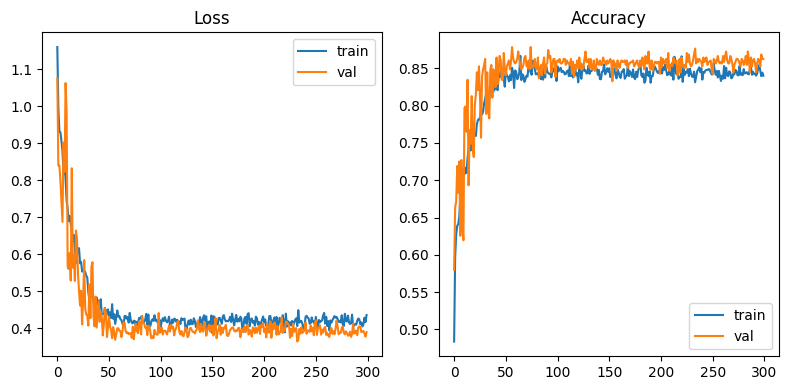

In [15]:
val_preds = np.concatenate(val_preds)
val_labels = np.concatenate(val_labels)

cm = confusion_matrix(val_labels, val_preds)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(val_labels, val_preds, target_names=class_names, digits=4))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.plot(history['train_loss'], label='train'); plt.plot(history['val_loss'], label='val'); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(history['train_acc'], label='train'); plt.plot(history['val_acc'], label='val'); plt.title("Accuracy"); plt.legend()
plt.tight_layout()
plt.show()